In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

class World:
    def __init__(self):
        self.height = height
        self.width = width
        self.obstacles = obstacles
        self.start = start
        self.goal = goal
        self.map = np.zeros((self.width, self.height))
        self.obstacle_list = []
        
        
        # setting random obstacles
        count = self.obstacles
        while(count):
            i = (random.randint(1, width-1), random.randint(1, height-1))
            if (i not in self.obstacle_list and i != self.goal):
                count = count - 1
                self.obstacle_list.append(i)
                self.map[i[0]][i[1]] = 1


In [24]:
def get_child_nodes(position, head, index):
    # [North, East, South, West]
    # input --> a position and the vehicle head (index of the "head" list that has the value 1)
    # output --> list of 3 nodes. 
    # Each node has --> { node position,
    #                     head (index) for that position,
    #                     action taken to reach that position,
    #                     cost of node node
    #                     index of the parent node in "closed_nodes" }
    cells = []
    if head == 0:
        cells.append(((position[0], position[1] + 1), head, 0, 0, index)) # cruise
        cells.append(((position[0] - 1, position[1]), 3, 1, 0, index))    # cruise left
        cells.append(((position[0] + 1, position[1]), 1, 2, 0, index))    # cruise right
    elif head == 1:
        cells.append(((position[0] + 1, position[1]), head, 0, 0, index))
        cells.append(((position[0], position[1] + 1), 0, 1, 0, index))
        cells.append(((position[0], position[1] - 1), 2, 2, 0, index))
    elif head == 2:
        cells.append(((position[0], position[1] - 1), head, 0, 0, index))
        cells.append(((position[0] + 1, position[1]), 1, 1, 0, index))
        cells.append(((position[0] - 1, position[1]), 3, 2, 0, index))
    elif head == 3:
        cells.append(((position[0] - 1, position[1]), head, 0, 0, index))
        cells.append(((position[0], position[1] - 1), 2, 1, 0, index))
        cells.append(((position[0], position[1] + 1), 0, 2, 0, index))
    return cells

def manhattan_cost(x, y):
    return sum(abs(val1-val2) for val1, val2 in zip(x, y))
    
def myFunc(e):
    return e[3] # fuction to return cost of a node. Used for sorting tree.

In [25]:
class Vehicle:
    def __init__(self, start, world):
        self.position = list(start)
        self.goal = world.goal
        self.head = [1,0,0,0] # Direction of the vehicle [North, East, South, West]
        self.map = np.zeros((world.height, world.width))
        self.real_map = world.map
        self.vision = 5 # camera strength
        self.speed = 0 # 0 = stop, 1
        self.path = [] # list of cells vehicle has already visited
        self.next_steps = [] # list of actions the vehicle should take next (0 = cruise, 1 = cruise left, 2 = cruise right)
    
    def update_map(self):
        # vehicle level perception
        # updates the vehicle map with respect to the position of the vehicle
        obstacle = False
        if self.head[0] == 1:
            for i in range(self.position[0] - self.vision, self.position[0] + self.vision + 1):
                if i >= 0 and i < width:
                    for j in range(self.position[1] + self.vision + 1):
                        if j >=0 and j < height:
                            self.map[i][j] = self.real_map[i][j]
                            if self.map[i][j]:
                                obstacle = True
        elif self.head[1] == 1:
            for i in range(self.position[0] + self.vision + 1):
                if i >= 0 and i < width:
                    for j in range(self.position[1] - self.vision, self.position[1] + self.vision + 1):
                        if j >=0 and j < height:
                            self.map[i][j] = self.real_map[i][j]
                            if self.map[i][j]:
                                obstacle = True
        elif self.head[2] == 1:
            for i in range(self.position[0] - self.vision, self.position[0] + self.vision + 1):
                if i >= 0 and i < width:
                    for j in range(self.position[1] - self.vision + 1):
                        if j >=0 and j < height:
                            self.map[i][j] = self.real_map[i][j]
                            if self.map[i][j]:
                                obstacle = True
        elif self.head[3] == 1:
            for i in range(self.position[0] - self.vision + 1):
                if i >= 0 and i < width:
                    for j in range(self.position[1] - self.vision, self.position[1] + self.vision + 1):
                        if j >=0 and j < height:
                            self.map[i][j] = self.real_map[i][j]
                            if self.map[i][j]:
                                obstacle = True
        return obstacle
    
    def update_path(self):
        self.next_steps.pop(0)
    
    def cruise(self):
        # moves the vehicle forward in the same direction
        self.position[0] = self.position[0] + (self.head[1] - self.head[3])
        self.position[1] = self.position[1] + (self.head[0] - self.head[2])
        
        
    def cruise_left(self):
        # moves the vehicle to the left cell and rotates head -90 degrees
        if self.head.index(1) == 0:
            self.head[0] = 0
            self.head[3] = 1
        else:
            self.head[self.head.index(1) - 1] = 1
            self.head[self.head.index(1) + 1] = 0 # There are 2 places where tha value is 1. Changing the 2nd one 
        self.position[0] = self.position[0] + (self.head[1] - self.head[3])
        self.position[1] = self.position[1] + (self.head[0] - self.head[2])
        
    
    def cruise_right(self):
        # moves the vehicle to the right cell and rotates head 90 degrees
        if self.head.index(1) == 3:
            self.head[0] = 1
            self.head[3] = 0
        else:
            self.head[self.head.index(1) + 1] = 1
            self.head[self.head.index(1)] = 0
        self.position[0] = self.position[0] + (self.head[1] - self.head[3])
        self.position[1] = self.position[1] + (self.head[0] - self.head[2])
        
    
    def astar(self):
        # updates the list "next_steps" with a set of instructions (according to the A* algorithm) to reach the goal
        # cruise = 0, cruise left = 1, cruise right = 2
        self.next_steps.clear()
        count = 0
        root = (self.position, self.head.index(1), 0, 0, None)
        tree = [] # A list of nodes that need to be explored
        # Each node has --> { node position,
        #                     head (index) for that position,
        #                     action taken to reach that position,
        #                     cost of node node
        #                     index of the parent node in "closed_nodes" }
        closed_nodes = [] # A list of nodes that have been explored
        tree.insert(count, root)
        while len(tree):
            parent_node = tree[0]
            tree.pop(0)
            if parent_node[0] == self.goal:
                node = parent_node
                while node[4] != 0: # retracing the path from goal to vehicle position
                    self.next_steps.append(node[2]) # action taken to reach that node
                    node = closed_nodes[node[4]]
                self.next_steps.append(node[2])
                self.next_steps.reverse() # list of actions to perform from vehicle position to goal
                break
            closed_nodes.insert(count, parent_node)
            children = get_child_nodes(parent_node[0], parent_node[1], count)
            count = count + 1
            cost = 0
            for child in children:
                if child not in closed_nodes:
                    if child[0][0] < width and child[0][1] < height and child[0][0] >= 0 and child[0][1] >= 0:
                        if not self.map[child[0][0]][child[0][1]]: # check of obstacle
                            # g(n) exact cost from vehicle position to new position 
                            # h(n) huristic cost from new position to goal
                            # i(n) speed
                            # f(n) = g(n) + h(n) - i(n)
                            cost = manhattan_cost(self.position, child[0]) + manhattan_cost(child[0], self.goal)
                            temp = list(child) # List <--> Tuple typecasting (cannot change values of a tuple)
                            temp[3] = cost
                            child = tuple(temp)
                            tree.append(child)
            random.shuffle(tree) # nodes with same cost should be chosen at random
            tree.sort(key = myFunc)


In [26]:
class Automata():
    def __init__(self):
        # Finite State Machine for Vehicle
        # States = {Enter, Cruise, Cruise Left, Cruise Right, Exit, Fail State}
        self.states = ['Enter', 'Cruise', 'Cruise_Left', 'Cruise Right', 'Exit', 'Fail State']
        self.state_count = [0, 0, 0, 0, 0, 0]
        self.state = 'Enter' # set initial state  
        self.world = World() # initialize world
        self.vehicle = Vehicle(start, self.world) # initialize vehicle in the world
        self.vehicle.update_map() # initialize vehicle perception
        self.vehicle.astar() # initialize vehicle planning
        self.transitions = 0
        self.matrix = np.zeros((6,6)) # State Transition Matrix: State(x) --> State(y)
    
    def start(self):
        self.transitions += 1
        self.state_count[0] += 1
        while tuple(self.vehicle.position) != self.vehicle.goal:
            if self.vehicle.next_steps[0] == 0:
                self.vehicle.cruise()
                self.matrix[self.states.index(self.state)][1] += 1
                self.state = self.states[1]
                self.state_count[1] += 1
            elif self.vehicle.next_steps[0] == 1:
                self.vehicle.cruise_left()
                self.matrix[self.states.index(self.state)][2] += 1
                self.state = self.states[2]
                self.state_count[2] += 1
            elif self.vehicle.next_steps[0] == 2:
                self.vehicle.cruise_right()
                self.matrix[self.states.index(self.state)][3] += 1
                self.state = self.states[3]
                self.state_count[3] += 1
            self.vehicle.update_path()
            if self.world.map[self.vehicle.position[0]][self.vehicle.position[1]]: # Collision check
                self.matrix[self.states.index(self.state)][5] += 1
                self.state = self.states[5]
                self.state_count[5] += 1
                self.transitions += 1
                break
            self.transitions += 1
            if self.vehicle.update_map():
                self.vehicle.astar()
            self.vehicle.path.append(tuple(self.vehicle.position))
        if tuple(self.vehicle.position) == self.vehicle.goal:
            self.matrix[self.states.index(self.state)][4] += 1
            self.state = self.states[4]
            self.state_count[4] += 1
            self.transitions += 1         
      

[[0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 2. 1. 0.]
 [0. 2. 0. 3. 0. 0.]
 [0. 2. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


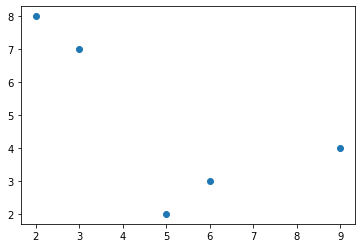

In [31]:
height = 10
width = 10
obstacles = 5
start = (0,0)
goal = (8,8)

machine = Automata()
machine.start()

print(machine.matrix)
plt.scatter(*zip(*machine.world.obstacle_list)) 


[0.         0.38888889 0.22222222 0.27777778 0.05555556 0.        ]
[(0, 1), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 5), (3, 6), (3, 7), (4, 7), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8)]


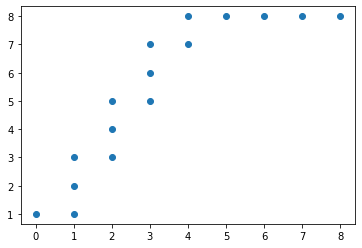

In [30]:
print(machine.vehicle.path)
plt.scatter(*zip(*machine.vehicle.path)) 

0.18


<BarContainer object of 6 artists>

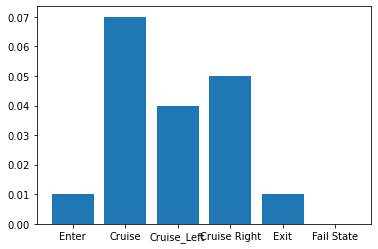

In [29]:
x = ['Enter', 'Cruise', 'Cruise_Left', 'Cruise Right', 'Exit', 'Fail State']
#y = [i / machine.transitions for i in machine.state_count]
y = [i / 100 for i in machine.state_count]
print(sum(y))
fig, ax = plt.subplots()
ax.bar(x, y)
